# Project Overview

Convolutional Neural Network (CNN) is a powerful tool commonly applied to image analysis
that is capable to outperform humans on some computer vision tasks.

Here an image classification pipeline for dog breed is presented.

The steps of this notebook are:

1. Clone the github repository with all the data to Google Drive
(an authorization is required).
2. Visualization of the training set.
3. Training of CNN model using transfer learning.
4. Classification of new data.



# Model

Given the large computer and time resources
required to develop neural network models,
**transfer learning** becomes an interesting option
on the area of computer vision.
In transfer learning,
a pre-trained model is used as starting point
for a second target network.

Here the [VGG-16](https://arxiv.org/abs/1409.1556)
model is used as starting point for image classification.



# Datasets

Two datasets are used in this project.

* ImageNet

  The pretrained VGG-16 model uses the
  [ImageNet](https://image-net.org/)
  database of images.
  This is a large database designed for use in visual object
  recognitiion.

* Images scraped from Google

  Additional data
  for training, validation and testing of the model
  was scrapped using Selenium,
  an open-source web-based automation tool.
  This additional was downloaded from google,
  compressed and stored in a
  [Github repository](https://github.com/oliveirampo/dog_breed_classification).
  New data can also be downloaded using the script provided
  [here](https://github.com/oliveirampo/dog_breed_classification/blob/main/scr/download_image.py).

# Metrics

The performance of the models trained is computed in terms of the accuracy, which is defined as
the number of corrected predictions divided by the total number of predictions, multiplyed by 100.

The dataset used here for image classification is balanced, thus accuracy is an appropriate option.
Otherwise, other metrics such as precision and recall could be better choices.



# Clone Repository and Import Libraries

Mount google drive - Click on the link and give authorization


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install selenium

     |████████████████████████████████| 911kB 29.1MB/s 


In [3]:
import sys
import os

In [4]:
projDir = '/content/drive/MyDrive/github_projects'

if not os.path.exists(projDir):
  os.makedirs(projDir)

%cd $projDir
%ls

/content/drive/MyDrive/github_projects
dog_breed_classification/  miniconda/


In [5]:
!git init .
!git clone https://github.com/oliveirampo/dog_breed_classification.git


Reinitialized existing Git repository in /content/drive/MyDrive/github_projects/.git/
fatal: destination path 'dog_breed_classification' already exists and is not an empty directory.


In [6]:
%cd $projDir/dog_breed_classification/

!git pull https://github.com/oliveirampo/dog_breed_classification.git

print()
%ls

/content/drive/MyDrive/github_projects/dog_breed_classification
From https://github.com/oliveirampo/dog_breed_classification
 * branch            HEAD       -> FETCH_HEAD
Already up to date.

data/  flask_app/  model/  README.md  requirements.txt  scr/  train_model.ipynb


Import libraries.

In [44]:
from scr import plot

In [150]:
%matplotlib inline 
import matplotlib.pyplot as plt
# from PIL import Image
import pandas as pd
import numpy as np

# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16

# from tensorflow.keras.preprocessing import image

# from keras.callbacks import ModelCheckpoint  

# from tensorflow.keras.models import load_model
# from tensorflow.keras.models import Model, Sequential

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from keras.layers import GlobalAvgPool2D, Dense, Flatten, Dropout
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input

from keras.models import Model
from keras.models import Sequential

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocess_input_xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as preprocess_input_inception_resnet_v2


# Load Data

In [8]:
# Get categories
df = pd.read_csv('data/dogs/labels.csv')
dog_breeds = sorted(df['breed'].unique())
n_classes = len(dog_breeds)

n_classes

114

In [9]:
# Converting classes to numbers
class_to_num = dict(zip(dog_breeds, range(n_classes)))
num_to_class = dict(zip(range(n_classes), dog_breeds))

In [ ]:
%ls data/dogs/

zip_file = 'data/dogs/train.zip'

train_directory = '/content/sample_data/train'
if not os.path.exists(train_directory):
  !unzip $zip_file -d /content/sample_data/


Load and convert images to array

In [11]:
def images_to_array(data_dir, df, image_size, class_to_num):
    image_names = df['id']
    image_labels = df['breed']
    data_size = len(image_names)
    # data_size = 70

    X = np.zeros([data_size, image_size[0], image_size[1], image_size[2]], dtype=np.uint8)
    y = np.zeros([data_size, 1], dtype=np.uint8)

    for i in range(data_size):
        img_name = image_names[i]
        img_dir = '{}/{}.png'.format(data_dir, img_name)
        img_pixels = load_img(img_dir, target_size=image_size)
        X[i] = img_pixels
        y[i] = class_to_num[image_labels[i]]

    y = to_categorical(y)

    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]

    return X, y

In [39]:
img_size = (224, 224, 3)
X, y = images_to_array(train_directory, df, img_size, class_to_num)
print(X.shape)
print(y.shape)

(6840, 224, 224, 3)
(6840, 114)


# Data Visualization

In [43]:
num_images = X.shape[0]

print('There are {} categories.'.format(n_classes))
print('There are {} images at total.'.format(X.shape[0]))
# print('There are {} ({:.1f} %) images at total.'.format(X.shape[0], 100.0 * X.shape[0] / num_images))

There are 114 categories.
There are 6840 images at total.


Example of images:

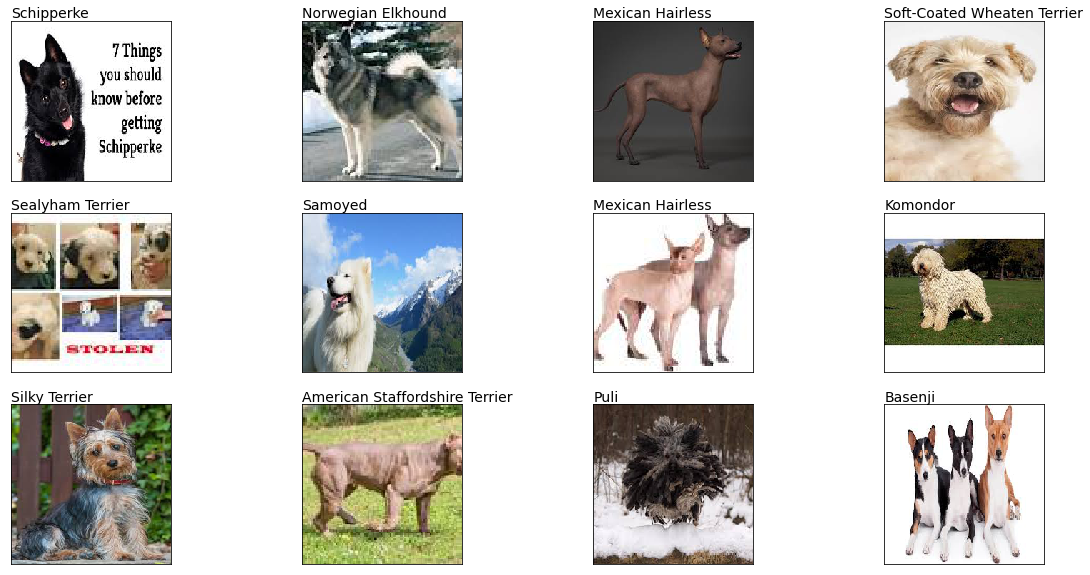

In [45]:
fig = plot.plot_images(3, 4, 12, X, y, num_to_class)

Note that this data has been downloaded from Google
and no cleaning steps were performed.

# Extract Features

In [158]:
def get_features(model_name, data_preprocessor, input_size, data):
    # Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    # Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=32, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

Extracting features using InceptionV3

In [159]:
inception_preprocessor = preprocess_input_inception_v3
inception_features = get_features(InceptionV3, inception_preprocessor,
                                  img_size, X)

214/214 [==============================] - 16s 70ms/step
Feature maps shape:  (6840, 2048)


Extracting features using Xception

In [23]:
xception_preprocessor = preprocess_input_xception
xception_features = get_features(Xception, xception_preprocessor,
                                 img_size, X)

214/214 [==============================] - 60s 123ms/step
Feature maps shape:  (6840, 2048)


Extracting features using InceptionResnetV2

In [26]:
inc_resnet_preprocessor = preprocess_input_inception_resnet_v2
inc_resnet_features = get_features(InceptionResNetV2,
                                    inc_resnet_preprocessor,
                                    img_size, X)

214/214 [==============================] - 41s 176ms/step
Feature maps shape:  (6840, 1536)


Concatenating features

In [161]:
final_features = np.concatenate([inception_features,
                                  xception_features,
                                  inc_resnet_features, ], axis=-1)
print('Final feature maps shape', final_features.shape)

Final feature maps shape (6840, 5632)


In [162]:
del X

# Model Training

In [163]:
#Callbacks
EarlyStop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [164]:
#Building Model
model = Sequential()
model.add(InputLayer(final_features.shape[1:]))
model.add(Dropout(0.7))
model.add(Dense(y.shape[1],activation='softmax'))

In [165]:
#Compiling Model
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [168]:
#Training Model
history = model.fit(final_features,
                  y,
                  batch_size=32,
                  epochs=50,
                  validation_split=0.1,
                  callbacks=my_callback)

Epoch 1/50
193/193 [==============================] - 1s 4ms/step - loss: 1.3608 - accuracy: 0.6756 - val_loss: 2.1679 - val_accuracy: 0.5848
Epoch 2/50
193/193 [==============================] - 1s 3ms/step - loss: 1.0771 - accuracy: 0.7329 - val_loss: 2.2454 - val_accuracy: 0.6053
Epoch 3/50
193/193 [==============================] - 1s 3ms/step - loss: 0.9413 - accuracy: 0.7599 - val_loss: 2.2289 - val_accuracy: 0.6038
Epoch 4/50
193/193 [==============================] - 1s 3ms/step - loss: 0.8004 - accuracy: 0.7893 - val_loss: 2.3497 - val_accuracy: 0.6053
Epoch 5/50
193/193 [==============================] - 1s 3ms/step - loss: 0.7374 - accuracy: 0.8012 - val_loss: 2.2936 - val_accuracy: 0.6126
Epoch 6/50
193/193 [==============================] - 1s 3ms/step - loss: 0.6790 - accuracy: 0.8226 - val_loss: 2.4378 - val_accuracy: 0.6140
Epoch 7/50
193/193 [==============================] - 1s 3ms/step - loss: 0.5954 - accuracy: 0.8351 - val_loss: 2.3553 - val_accuracy: 0.6228
Epoch 

In [143]:
def train_model_2(img_size, X, y):
  vgg16_preprocessor = preprocess_input_vgg16
  vgg16_features = get_features(VGG16, vgg16_preprocessor, img_size, X)
  final_features = np.concatenate([vgg16_features,], axis=-1)
  print('Final feature maps shape', final_features.shape)

  #Callbacks
  EarlyStop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  my_callback = [EarlyStop_callback]

  #Building Model2
  model = Sequential()
  model.add(InputLayer(final_features.shape[1:]))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.7))
  model.add(Dense(y.shape[1],activation='softmax'))

  #Compiling Model
  model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  
  #Training Model
  history = model.fit(vgg16_features,
                  y,
                  batch_size=32,
                  epochs=100,
                  validation_split=0.1,
                  callbacks=my_callback)
  
  return model, history


In [144]:
model_2, history_2 = train_model_2(img_size, X, y)

214/214 [==============================] - 27s 128ms/step
Feature maps shape:  (6840, 512)
Final feature maps shape (6840, 512)
Epoch 1/100
193/193 [==============================] - 1s 3ms/step - loss: 9.7738 - accuracy: 0.0479 - val_loss: 3.3320 - val_accuracy: 0.2646
Epoch 2/100
193/193 [==============================] - 1s 3ms/step - loss: 3.6471 - accuracy: 0.1920 - val_loss: 2.5978 - val_accuracy: 0.3889
Epoch 3/100
193/193 [==============================] - 1s 3ms/step - loss: 3.1218 - accuracy: 0.2665 - val_loss: 2.3658 - val_accuracy: 0.4240
Epoch 4/100
193/193 [==============================] - 1s 3ms/step - loss: 2.7610 - accuracy: 0.3321 - val_loss: 2.1641 - val_accuracy: 0.4751
Epoch 5/100
193/193 [==============================] - 1s 3ms/step - loss: 2.6022 - accuracy: 0.3531 - val_loss: 2.0764 - val_accuracy: 0.4635
Epoch 6/100
193/193 [==============================] - 1s 3ms/step - loss: 2.3651 - accuracy: 0.4001 - val_loss: 2.0237 - val_accuracy: 0.4912
Epoch 7/100
19

## Save best model

In [ ]:
model_path = projDir + 'dog_breed_classification/model'
model_path

'/content/drive/MyDrive/github_projects/dog_breed_classification/model'

In [ ]:
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/github_projects/dog_breed_classification/model/assets


Reconstruct the trained model


In [ ]:
model = load_model(model_path)

In [145]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 5632)              0         
_________________________________________________________________
dense (Dense)                (None, 114)               642162    
Total params: 642,162
Trainable params: 642,162
Non-trainable params: 0
_________________________________________________________________


# Results

## Evolution of Loss Function

In [191]:
def plot_optimization_Results(history):
  """Plot evolution of optimization.
  
  :param history (tensorflow History)
  """

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # epochs_range = range(epochs)
  epochs_range = range(len(acc))

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

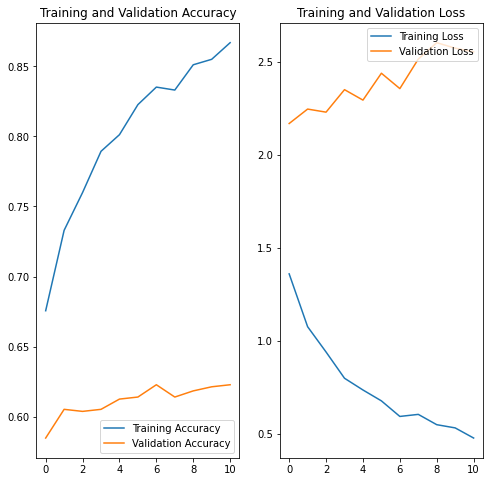

In [192]:
plot_optimization_Results(history)

## Model Accuracy

In [ ]:
def array_to_image(dataset):
  data = []

  for i in range(dataset.shape[0]):
    img = Image.fromarray(np.uint8(dataset[i] * dataset.shape[1]))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    data.append(x[0])

  data = np.array(data)

  return data

In [ ]:
def get_accuracy(model, x_test, test_targets, categories):
  x_test_processed = array_to_image(x_test)

  # predict classes
  features = model.predict(x_test_processed)
  top_indices = np.array([features[i].argsort()[-1] for i in range(features.shape[0])])
  predicted_classes = np.array([categories[str(i).lower()] for i in top_indices])

  # get actual classes
  _, cols = np.where(test_targets == 1)
  actual_classes = np.array([categories[str(i).lower()] for i in cols])

  # compare predicted and actual values
  results_bool = (predicted_classes == actual_classes)

  # compute accuracy
  accuracy = np.sum(results_bool) / results_bool.shape[0]

  return accuracy


In [ ]:
model.evaluate(x_test, test_targets)

36/36 [==============================] - 55s 441ms/step - loss: 3.8624 - accuracy: 0.1351


[3.8623714447021484, 0.13508771359920502]

In [ ]:
x_test_processed = array_to_image(x_test)
model.evaluate(x_test_processed, test_targets)

36/36 [==============================] - 9s 247ms/step - loss: 76.6917 - accuracy: 0.1018


[76.69168853759766, 0.10175438225269318]

In [ ]:
accuracy = get_accuracy(model, x_test, test_targets, categories)
print('Accuracy = {:.2f}'.format(accuracy))

Accuracy = 0.10


## Testing on Additional Images

In [ ]:
test_image_path = projDir + 'dog_breed_classification/data/inp/additional_test_image.jpg'
%ls $test_image_path

/content/drive/MyDrive/github_projects/dog_breed_classification/data/inp/additional_test_image.jpg


In [ ]:
def classify_image(img_path, model, top=3):
    """Example from Keras of how to classify single image with given model."""

    img = image.load_img(img_path, target_size=(224, 224))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)[0]
    
    top_indices = features.argsort()[-top:][::-1]
    results = [{"breed": categories[str(i)], "percentage": '{:.2f}'.format(features[i] * 100.0)} for i in top_indices]
    return results

In [ ]:
results = classify_image(test_image_path, model)
results

[{'breed': 'american_staffordshire_terrier', 'percentage': '100.00'},
 {'breed': 'bull_terrier', 'percentage': '0.00'},
 {'breed': 'basenji', 'percentage': '0.00'}]

# Accuracy of VGG16 model with test images

In [ ]:
projDir = '/content/drive/MyDrive/github_projects/'
test_image_path = projDir + 'dog_breed_classification/data/inp/additional_test_image.jpg'

In [ ]:
%ls $projDir

airbnb_seatle/  app/  dog_breed_classification/  miniconda/  README.md


In [ ]:
def classify_image_vgg16(img_path, model):
    """Example from Keras of how to classify single image with given model."""

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    # print('Predicted:', decode_predictions(features, top=3)[0])
    results = decode_predictions(features, top=3)
    results = [{"breed": res[1], 'percentage': '({:.2f} %)'.format(res[2] * 100.0)} for res in results[0]]
    for res in results: print(res)


In [ ]:
pretrained_model = VGG16(weights='imagenet')

In [ ]:
pretrained_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
classify_image_vgg16(test_image_path, pretrained_model)

{'breed': 'Doberman', 'percentage': '(57.57 %)'}
{'breed': 'miniature_pinscher', 'percentage': '(28.77 %)'}
{'breed': 'kelpie', 'percentage': '(8.08 %)'}


In [ ]:
def get_accuracy_pretrained_model(model, x_test, test_targets, categories):
  # preprocess data
  x_test_processed = array_to_image(x_test)

  # get predictions
  features = model.predict(x_test_processed)
  results = decode_predictions(features, top=1)
  results = np.array(results)

  # process prediction (convert strings to lower case)
  predicted_classes = results[:, 0][:, 1]
  predicted_classes = np.array([s.lower() for s in predicted_classes])

  # get actual classes
  _, cols = np.where(test_targets == 1)
  actual_classes = np.array([categories[str(i).lower()] for i in cols])

  # compare predicted and actual values
  results_bool = (predicted_classes == actual_classes)

  # compute accuracy
  accuracy = np.sum(results_bool) / results_bool.shape[0]

  return accuracy


In [ ]:
accuracy = get_accuracy_pretrained_model(pretrained_model, x_test, test_targets, categories)
print('Accuracy = {:.2f}'.format(accuracy))

Accuracy = 0.22


# TODO

- Check what classes are misclassified.